# Ridge Regression Evaluation

This notebook trains **Ridge regression models per drug** using gene expression features.  
Ridge applies L2 regularization, which helps stabilize the model with high-dimensional data like gene expression.

We use `RidgeCV` for automatic hyperparameter tuning with 5-fold cross-validation.

Ridge Regression is a linear model with **L2 regularization**, which helps prevent overfitting by shrinking model coefficients. It's simple, fast, and often performs well on high-dimensional data.

We evaluate performance using:
- **RMSE (Root Mean Squared Error)**: average error magnitude
- **R² (Coefficient of Determination)**: variance explained by the model

We'll also visualize the **distribution** of these metrics across all drugs to understand the model's general behavior.


In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
NUM_PCS = 20

DATA_PATH = "../../../data/bulk/bulk_with_pca.parquet"
data = pd.read_parquet(DATA_PATH)

print("✅ Dataset loaded:", data.shape)


✅ Dataset loaded: (571985, 23)


## 1. Compute Metrics per Drug

For each drug:
- Select relevant (cell line, drug) rows
- Train/test split
- Fit a **Ridge Regression** model on PCA components
- Evaluate with **RMSE** and **R²**

We skip drugs with < 10 samples to ensure stability.


In [3]:
os.makedirs("results/ridge_regression", exist_ok=True)

non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [col for col in data.columns if col not in non_features]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

results = []

for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 10:
        continue

    X = df[gene_cols].values
    y = df["LN_IC50"].values

    model = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=kf)
    model.fit(X, y)

    rmse_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "alpha": model.alpha_,
        "rmse_mean": -rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "r2_mean": r2_scores.mean(),
        "r2_std": r2_scores.std()
    })



In [4]:
results_df = pd.DataFrame(results)
results_df.to_csv(f"results/ridge_regression/ridge_regression_results_{NUM_PCS}_pcs.csv", index=False)

print("📁 Saved to results/ridge_regression_results_cv.csv")
results_df.head()


📁 Saved to results/ridge_regression_results_cv.csv


,DRUG_ID,n_samples,alpha,rmse_mean,rmse_std,r2_mean,r2_std
0,1,391,10.0,1.054269,0.182128,0.074302,0.104687
1,3,356,10.0,1.955382,0.207201,0.030715,0.029738
2,5,394,10.0,1.496337,0.130821,0.174304,0.075185
3,6,403,10.0,0.898422,0.131805,-0.026933,0.126595
4,9,396,10.0,1.430242,0.168837,0.030681,0.116307


## 2. RMSE Distribution

We visualize the distribution of **RMSE** values across drugs to assess:
- General prediction accuracy
- Variability of model performance


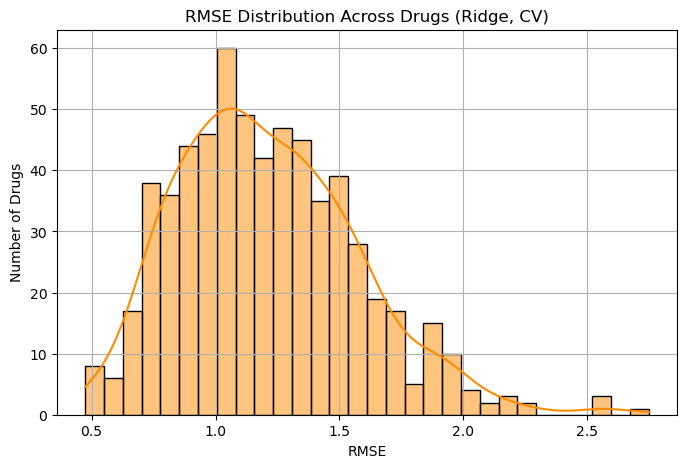

In [5]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="darkorange")
plt.title("RMSE Distribution Across Drugs (Ridge, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"results/ridge_regression/ridge_regression_rmse_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()

## 3. R² Distribution

This shows how much variance Ridge Regression captures in IC50 values across different drugs.

- **R² > 0**: model is better than the mean predictor
- **R² < 0**: model is worse than predicting the mean


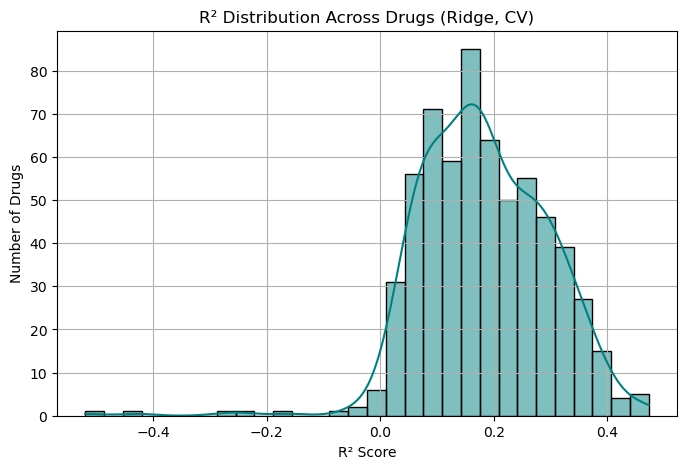

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="teal")
plt.title("R² Distribution Across Drugs (Ridge, CV)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"results/ridge_regression/ridge_regression_r2_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()

## 4. Summary

Ridge Regression adds L2 regularization to linear regression, making it more stable on high-dimensional data.

From the plots:
- We see how prediction errors (RMSE) vary by drug
- R² scores give insight into the **variance explained** per drug

This model gives a strong linear baseline to beat, especially when features are dense and multicollinear.
